Manual GridSearch

--- Starting Manual Hyperparameter Search ---

Trial 1: Testing params: {'units_1': 32, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.2, 'learning_rate': 0.001}
Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 0.2443 - val_loss: 0.0689
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0362 - val_loss: 0.0093
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0169 - val_loss: 0.0127
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0128 - val_loss: 0.0096
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0116 - val_loss: 0.0076
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0128 - val_loss: 0.0066
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0112 - val_loss: 0.0070
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.

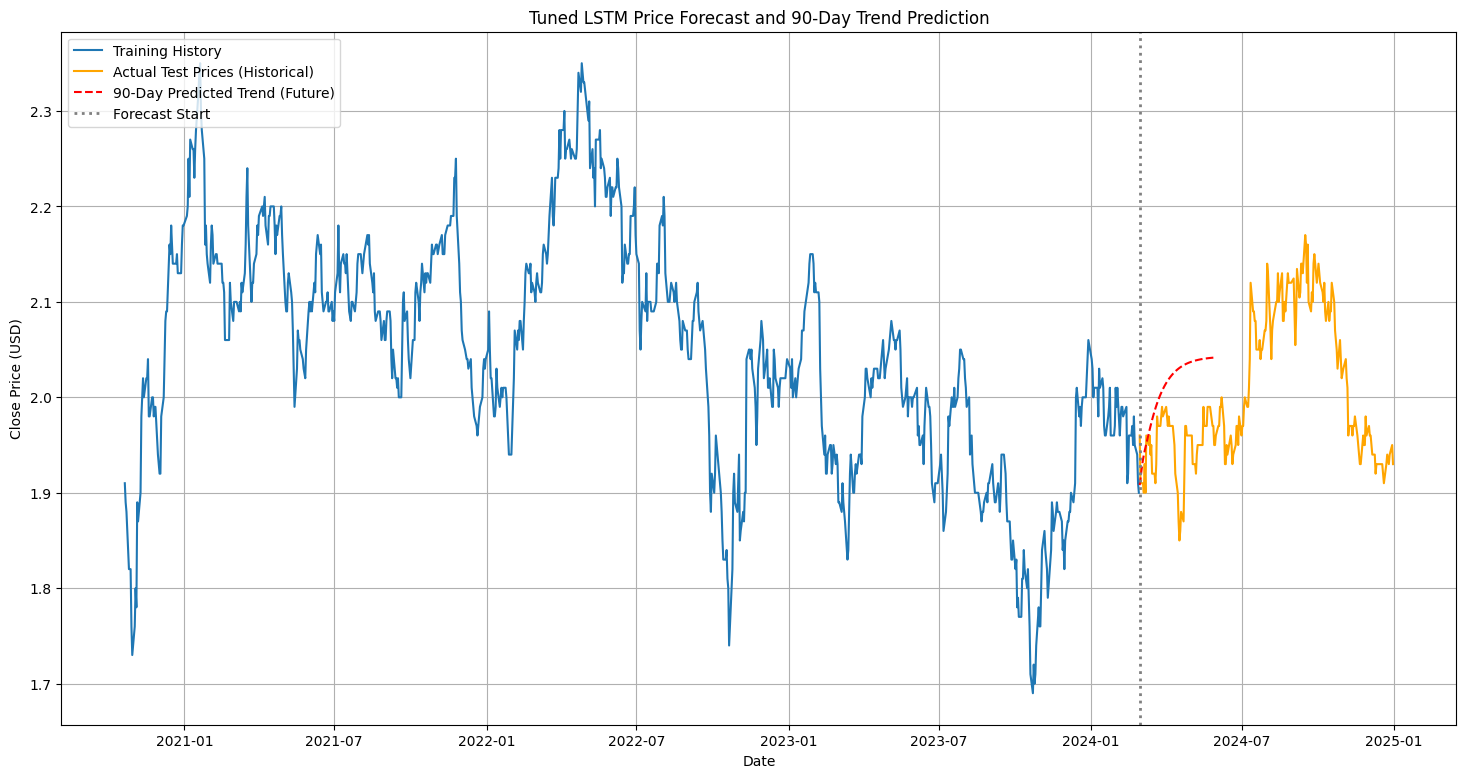

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Input 

# --- 1. Load and Prepare Data ---
df = pd.read_csv('calculated_averages/C38U.SI_stock_price_history_with_indicators.csv', parse_dates=['Date'], index_col='Date')
data = df.filter(['Close'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# --- 2. Create Sequences ---
SEQ_LEN = 180
train_data_len = int(np.ceil(len(dataset) * .8))
train_data = scaled_data[0:int(train_data_len), :]

x_train = []
y_train = []
for i in range(SEQ_LEN, len(train_data)):
    x_train.append(train_data[i-SEQ_LEN:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# --- 3. Manual Hyperparameter Tuning Loop ---

# Define Parameter Options
options_units_1       = [32, 64]
options_dropout_1     = [0.2, 0.4]
options_units_2       = [32, 64]
options_dropout_2     = [0.2, 0.4]
options_learning_rate = [1e-3, 1e-2, 1e-4]

# Build the Grid for the Tuner
param_grid = {
    'units_1':       options_units_1,
    'dropout_1':     options_dropout_1,
    'units_2':       options_units_2,
    'dropout_2':     options_dropout_2,
    'learning_rate': options_learning_rate,
}

# Variables to store the best results
best_score = float('inf')
best_params = {}
trial_count = 0

# Model building function 
def create_model(units_1, dropout_1, units_2, dropout_2, learning_rate):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1], 1))) 
    model.add(LSTM(units=units_1, return_sequences=True)) 
    model.add(Dropout(dropout_1))
    model.add(LSTM(units=units_2, return_sequences=False))
    model.add(Dropout(dropout_2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Loop through every combination
print("--- Starting Manual Hyperparameter Search ---")
for u1 in param_grid['units_1']:
    for d1 in param_grid['dropout_1']:
        for u2 in param_grid['units_2']:
            for d2 in param_grid['dropout_2']:
                for lr in param_grid['learning_rate']:
                    trial_count += 1
                    current_params = {'units_1': u1, 'dropout_1': d1, 'units_2': u2, 'dropout_2': d2, 'learning_rate': lr}
                    print(f"\nTrial {trial_count}: Testing params: {current_params}")

                    model = create_model(**current_params)
                    history = model.fit(
                        x_train,
                        y_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                        verbose=1
                    )

                    min_val_loss = min(history.history['val_loss'])
                    if min_val_loss < best_score:
                        print(f"  -> New best score: {min_val_loss:.4f}")
                        best_score = min_val_loss
                        best_params = current_params

print("\n--- Search Complete ---")
print(f"Best validation loss: {best_score:.4f}")
print(f"Best parameters found: {best_params}")

# --- 4. Build and Train the Final Model with Best Parameters ---
print("\n--- Building and training the final, best model ---")
model = create_model(**best_params)
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=100,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    validation_split=0.1
)

# --- 5. Perform Iterative Forecasting & Visualization ---
# (The rest of your code remains the same)
N_STEPS = 90
print(f"\n--- Starting Iterative Trend Forecasting for {N_STEPS} days ---")
initial_sequence = scaled_data[train_data_len - SEQ_LEN:train_data_len].tolist()
current_input = np.array(initial_sequence).reshape(1, SEQ_LEN, 1)
future_predictions_scaled = []

for i in range(N_STEPS):
    next_prediction_scaled = model.predict(current_input, verbose=0)[0, 0]
    future_predictions_scaled.append(next_prediction_scaled)
    new_input_list = current_input[0, :, 0].tolist()
    new_input_list.pop(0)
    new_input_list.append(next_prediction_scaled)
    current_input = np.array(new_input_list).reshape(1, SEQ_LEN, 1)

predictions_array = np.array(future_predictions_scaled).reshape(-1, 1)
future_predictions_price = scaler.inverse_transform(predictions_array)
last_train_date = df.index[train_data_len - 1]
future_dates = pd.date_range(start=last_train_date, periods=N_STEPS + 1, inclusive='right')
future_df = pd.DataFrame(future_predictions_price, index=future_dates, columns=['Predicted_Trend_Price'])

# Visualize the Results
train = data[:train_data_len]
valid = data[train_data_len:]
plt.figure(figsize=(18, 9))
plt.title(f'Tuned LSTM Price Forecast and {N_STEPS}-Day Trend Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train['Close'], label='Training History')
plt.plot(valid['Close'], label='Actual Test Prices (Historical)', color='orange')
plt.plot(future_df['Predicted_Trend_Price'], label=f'{N_STEPS}-Day Predicted Trend (Future)', color='red', linestyle='--')
forecast_start_date = future_df.index[0]
plt.axvline(x=forecast_start_date, color='grey', linestyle=':', linewidth=2, label='Forecast Start')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()